<a href="https://colab.research.google.com/github/mirpouya/Pytorch_Tutorial/blob/main/02_1_PyTorch_Neural_Network_Classification_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
torch.__version__

'2.0.1+cu118'

In [2]:
from sklearn.datasets import make_circles


# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

In [3]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


In [4]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [5]:
# Check different labels
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

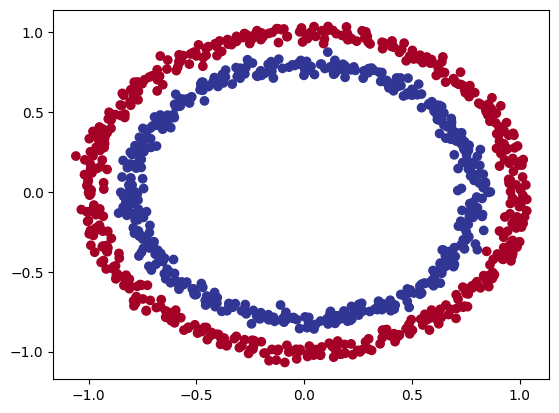

In [6]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

In [7]:
# Check the shapes of our features and labels
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


In [9]:
# Turn data into tensors
# Otherwise this causes issues with computations later on
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [10]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

### <b> download helper function <b>

In [11]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

## 1. The missing piece of our previous model was: NON-LINEARITY

<b> Building a model with non-linear activation functions </b>

In [12]:
# device agnostic code

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [13]:
from torch import nn

class CircleModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features = 2, out_features = 10)
    self.layer_2 = nn.Linear(in_features = 10, out_features = 10)
    self.layer_3 = nn.Linear(in_features = 10, out_features = 1)
    # the non-linear activation function
    self.relu = nn.ReLU()

    # we can define sigmoid layer here, or we can feed layer 3 outputs to sigmoid layer in training loop

  def forward(self, x):
    # Intersperse the ReLU activation function between layers
    # where should we put non-linear activation functions?
    # we can put an activation function in between each of our layers
      return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))


model_non_linear = CircleModel().to(device)
model_non_linear

CircleModel(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

<b> training loop </b>

In [14]:
# loss function and optimizer

loss_fn = nn.BCEWithLogitsLoss()  # sigmoid activation function built in
optimizer = torch.optim.SGD(params = model_non_linear.parameters(), lr = 0.08)

In [15]:
# accuracy function

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [16]:
# data t device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test , y_test = X_test.to(device), y_test.to(device)

In [17]:
# Fit the model
torch.manual_seed(42)
epochs = 2000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_non_linear(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_non_linear.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_non_linear(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69492, Accuracy: 50.00% | Test Loss: 0.69412, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69254, Accuracy: 49.25% | Test Loss: 0.69225, Test Accuracy: 44.50%
Epoch: 200 | Loss: 0.69062, Accuracy: 55.00% | Test Loss: 0.69082, Test Accuracy: 51.50%
Epoch: 300 | Loss: 0.68944, Accuracy: 56.50% | Test Loss: 0.68983, Test Accuracy: 52.00%
Epoch: 400 | Loss: 0.68796, Accuracy: 57.25% | Test Loss: 0.68868, Test Accuracy: 54.00%
Epoch: 500 | Loss: 0.68599, Accuracy: 58.13% | Test Loss: 0.68727, Test Accuracy: 56.00%
Epoch: 600 | Loss: 0.68331, Accuracy: 58.63% | Test Loss: 0.68547, Test Accuracy: 58.00%
Epoch: 700 | Loss: 0.67956, Accuracy: 62.38% | Test Loss: 0.68303, Test Accuracy: 60.50%
Epoch: 800 | Loss: 0.67435, Accuracy: 64.88% | Test Loss: 0.67975, Test Accuracy: 63.50%
Epoch: 900 | Loss: 0.66715, Accuracy: 66.25% | Test Loss: 0.67509, Test Accuracy: 64.00%
Epoch: 1000 | Loss: 0.65699, Accuracy: 68.00% | Test Loss: 0.66758, Test Accuracy: 64.50%
Epoch: 1100 | Loss: 0.

In [18]:
model_non_linear.parameters

<bound method Module.parameters of CircleModel(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)>

In [19]:
model_non_linear.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-1.7241,  1.2760],
                      [-1.0566,  0.7495],
                      [ 1.0974, -1.0950],
                      [-0.5156,  0.2401],
                      [ 0.4599,  2.3859],
                      [-2.4208, -1.1229],
                      [ 0.0380,  0.0459],
                      [-0.6037,  0.5338],
                      [ 0.0148, -0.0902],
                      [ 0.4283, -0.6671]])),
             ('layer_1.bias',
              tensor([-0.6103,  1.4299,  0.1908,  0.6389, -0.0611, -0.2650,  0.6867,  0.8102,
                       0.4996,  0.8496])),
             ('layer_2.weight',
              tensor([[ 5.7465e-01,  9.7606e-02, -3.1533e-01, -1.2983e-03,  8.9389e-01,
                        8.8779e-01, -3.2646e-01,  3.1368e-01, -1.3258e-01, -5.8979e-01],
                      [-4.2069e-01,  9.3373e-01, -8.7261e-02,  5.3215e-01, -4.1344e-01,
                       -8.2227e-01,  4.1798e-01,  2.8817e-01,  3.0628e-01,  5.851

## <b> Draw decision boundary </b>

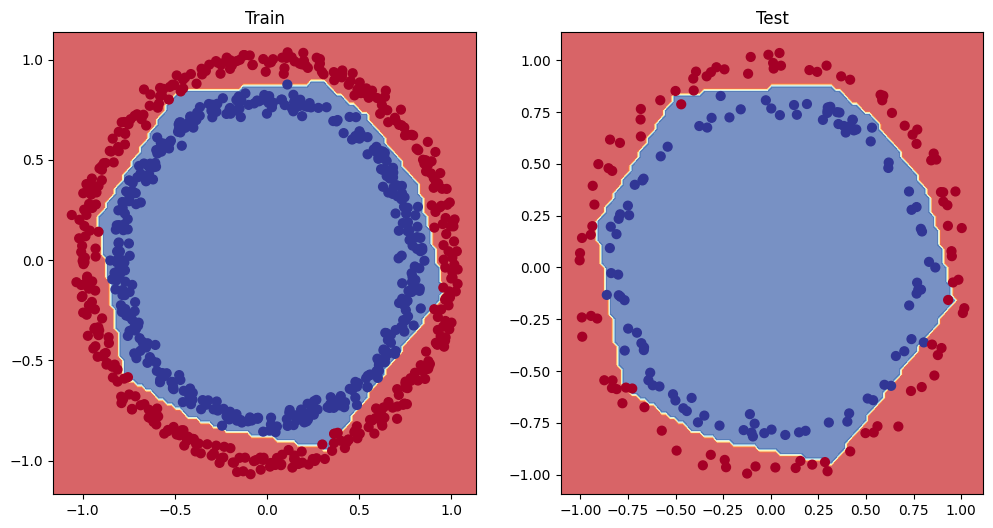

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_non_linear, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_non_linear, X_test, y_test)

## <b> Multi-Class classification </b>

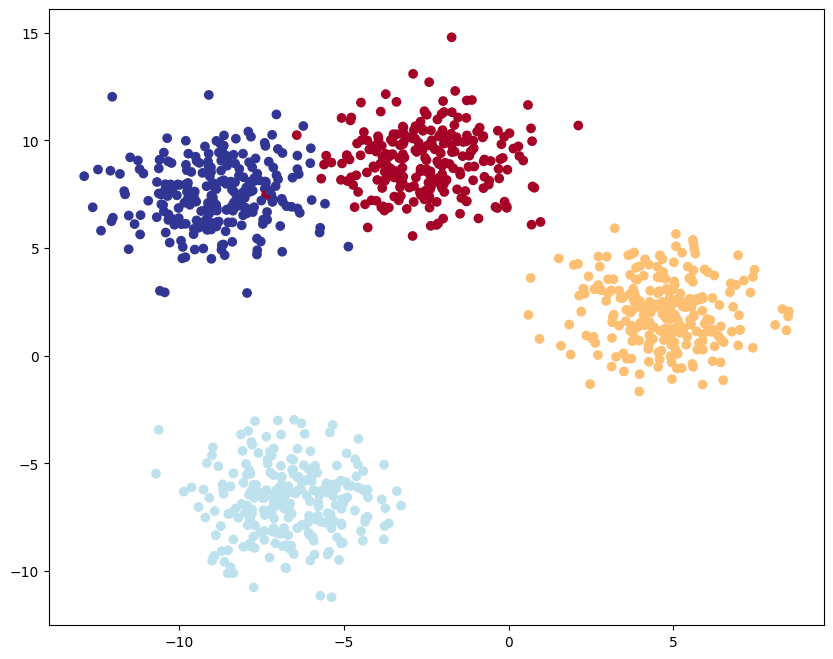

In [29]:
# creating a multi-class dataset

import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# set the hyperparameters
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. create multi-class data

X_blobs, y_blobs = make_blobs(n_samples = 1000, n_features = NUM_FEATURES,
                              centers = NUM_CLASSES,
                              cluster_std = 1.5, random_state = RANDOM_SEED)

# 2. turn data into tensors
X_blobs = torch.from_numpy(X_blobs).type(torch.float)
y_blobs = torch.from_numpy(y_blobs).type(torch.float)

# 3. train test splits
X_blobs_train, X_blobs_test, y_blobs_train, y_blobs_test = train_test_split(X_blobs,
                                                                            y_blobs,
                                                                            test_size=0.2,
                                                                            random_state = RANDOM_SEED)

# 4. plot the data
plt.figure(figsize = (10, 8))
plt.scatter(X_blobs[:, 0], X_blobs[:, 1], c = y_blobs, cmap = plt.cm.RdYlBu)

### <b> Building a multi-class classification model </b>

In [30]:
# create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [36]:
# multi-class classification model
from torch import nn

class BlobModel_multi_class(nn.Module):
  def __init__(self, input_features, output_features, hidden_units = 8):
    super().__init__()

    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features = input_features, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = output_features),
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

In [37]:
# create an instance of blob model and send it to the target device

model_blob_multiClass = BlobModel_multi_class(input_features = 2,
                                              output_features = 4,
                                              hidden_units = 8).to(device)

model_blob_multiClass

BlobModel_multi_class(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

### <b> Create a loss function </b>

In [38]:
# loss and optimizer
# for binary classifications `BCELoss` or `BCEWithLogitsLoss` is used
# for multi class classification `CrossEntropyLoss` is used

loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(params = model_blob_multiClass.parameters(),
                            lr = 0.1)

### <b> Getting prediction probabilities for multi-class PyTorch model </b>

raw outputs of the model, before sigmoid or softmax, is called logits

In [43]:
next(model_blob_multiClass.parameters()).device

device(type='cpu')

In [44]:
model_blob_multiClass.eval()
with torch.inference_mode():
  y_preds = model_blob_multiClass(X_blobs_test.to(device))

y_preds[:10]

tensor([[-0.2808, -0.1917, -0.0700,  0.5581],
        [ 0.2334, -0.2277,  0.6167, -0.4486],
        [-0.3333,  0.0639,  1.0439, -0.2317],
        [-0.2139, -0.1545,  0.0168,  0.4633],
        [-0.1981,  0.0649,  0.2720,  0.1182],
        [ 0.3842, -0.3895,  0.6811, -0.6076],
        [-0.4305,  0.2444,  0.9203, -0.2199],
        [-0.0705,  0.0528,  0.4245, -0.0542],
        [-0.0514, -0.2772,  1.2965, -0.3868],
        [-0.0966,  0.0741,  0.4042, -0.0217]])

In [45]:
y_blobs_test[:10]

tensor([1., 3., 2., 1., 0., 3., 2., 0., 2., 0.])

as you see, `y_preds` and `y_blobs_test` don't have the same format

In order to evaluate and train and test our model, we need to convert our model's outputs (logits) to prediction probabilities and then to prediction labels.